In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

In [2]:
torch.cuda.set_device("cuda:7") # change this every time after salloc

In [9]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

#run_id = "2b59a61e-2810-49e3-b70c-402437ec871b"  # if you train more models, replace with the run_id from the table above
#n_layer = 3
#n_head = 2
#run_id = f"pretrained_head_{n_head}_layer_{n_layer}"
run_id = "2e4dc4ae-fd23-4308-be77-351afc5f9009" # no softmax == uniform attention
run_path = os.path.join(run_dir, task, run_id)

base_id = "pretrained"
base_path = os.path.join(run_dir, task, base_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [4]:
from samplers import get_data_sampler
from tasks import get_task_sampler
import models
from eval import eval_batch, aggregate_metrics
from sklearn.metrics import r2_score
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os

# Visualizing Attention

In [12]:
model, conf = get_model_from_run(run_path)
model.eval()
model.output_attentions=True

base_model, base_conf = get_model_from_run(base_path)
base_model.eval()

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

In [14]:
data_sampler = get_data_sampler('gaussian', n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

with torch.no_grad():
    ys_pred, output = model(xs, ys)
    ys_pred_base = base_model(xs, ys)

gaussian


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_70501/1777641834.py:23 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_70501/1777641834.py'                        │
│                                                                                                  │
│ /home/deqingfu/miniconda3/envs/transformers/lib/python3.8/site-packages/matplotlib/pyplot.py:266 │
│ 7 in legend                                                                                      │
│                                                                                                  │
│   2664 # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.                  │
│   2665 @_copy_docstring_and_deprecators(Axes.legend)                                             │
│   2666 def legend(*args, **kwargs):                                                              │
│ ❱ 2667 │   return gca().legend(*args, **kwargs)                                                  │
│   2668                                                                                           │
│   2669                                                                                           │
│   2670 # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.                  │
│                                                                                                  │
│ /home/deqingfu/miniconda3/envs/transformers/lib/python3.8/site-packages/matplotlib/axes/_axes.py │
│ :305 in legend                                                                                   │
│                                                                                                  │
│    302 │   │   │   │   **kwargs)                                                                 │
│    303 │   │   if len(extra_args):                                                               │
│    304 │   │   │   raise TypeError('legend only accepts two non-keyword arguments')              │
│ ❱  305 │   │   self.legend_ = mlegend.Legend(self, handles, labels, **kwargs)                    │
│    306 │   │   self.legend_._remove_method = self._remove_legend                                 │
│    307 │   │   return self.legend_                                                               │
│    308                                                                                           │
│                                                                                                  │
│ /home/deqingfu/miniconda3/envs/transformers/lib/python3.8/site-packages/matplotlib/legend.py:455 │
│ in __init__                                                                                      │
│                                                                                                  │
│    452 │   │   │   if not self.isaxes and loc in [0, 'best']:                                    │
│    453 │   │   │   │   loc = 'upper right'                                                       │
│    454 │   │   if isinstance(loc, str):                                                          │
│ ❱  455 │   │   │   loc = _api.check_getitem(self.codes, loc=loc)                                 │
│    456 │   │   if not self.isaxes and loc == 0:                                                  │
│    457 │   │   │   raise ValueError(                                                             │
│    458 │   │   │   │   "Automatic legend placement (loc='best') not implemented for "            │
│                                                                                                  │
│ /home/deqingfu/miniconda3/envs/transformers/lib/python3.8/site-packages/matplotlib/_api/__init__ │
│ .py:188 in check_getitem                                   

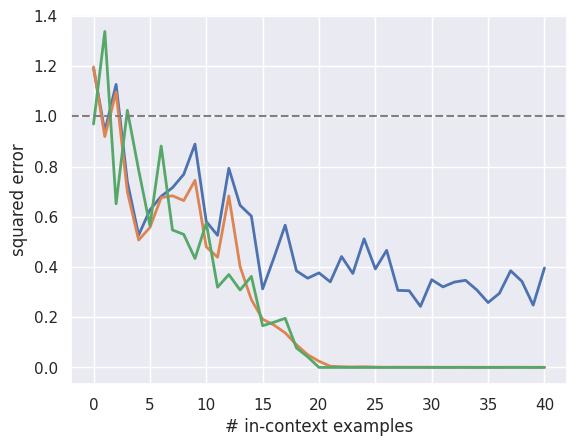

In [16]:
metric = task.get_metric()
loss_gau = metric(ys_pred, ys)
loss_base = metric(ys_pred_base, ys)


sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": 1.0,
}[conf.training.task]

plt.plot(loss_gau.mean(axis=0)/n_dims, lw=2, label="Transformer (Uniform Attention)")
plt.plot(loss_base.mean(axis=0)/n_dims, lw=2, label="Transformer (with Attention)")

lstsq_model = models.LeastSquaresModel()
lstsq_gau = aggregate_metrics(eval_batch(lstsq_model, task_sampler, xs))['mean']
plt.plot(np.array(lstsq_gau)/n_dims, lw=2, label=f"Least Square")

plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
#plt.title("Comparison on Gaussian Data")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
#plt.yscale("log")
plt.legend(loc="upper right", fontsize=8)
plt.show()

In [41]:
n_data = 21
pad_cls = 1
if pad_cls == 1:
    assert conf.model['use_cls']
for layer in range(conf.model['n_layer']):
    g = sn.heatmap(output.attentions[layer][0].mean(axis=0).data.cpu().numpy()[1-pad_cls:n_data*2+1,1-pad_cls:n_data*2+1], \
                   xticklabels=True, yticklabels=True, linecolor='white', linewidths=0.1)
    ticklabels = np.array([[f'$x_{{{i}}}$', f'$y_{{{i}}}$'] for i in range(1, n_data)]).flatten().tolist() + [r'$x_{query}$', r'$y_{query}$']
    if pad_cls == 1: ticklabels = ['[CLS]'] + ticklabels
    g.set_xticklabels(ticklabels, rotation=90, fontsize=8)
    g.set_yticklabels(ticklabels, fontsize=8)
    
    folder = f"/home/deqingfu/in-context-learning/attentions_{run_id}/layer{layer}/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    plt.savefig(folder + f"{layer}.png", \
                bbox_inches='tight', pad_inches=0.1, dpi=500)
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [42]:
for layer in range(conf.model['n_layer']):
    folder = f"/home/deqingfu/in-context-learning/attentions_{run_id}/layer{layer}/"
    if not os.path.exists(folder):
        os.makedirs(folder)
    for head in range(conf.model['n_head']):
        g = sn.heatmap(output.attentions[layer][0][head].data.cpu().numpy()[1-pad_cls:n_data*2+1,1-pad_cls:n_data*2+1], \
                       xticklabels=True, yticklabels=True, linecolor='white', linewidths=0.1)
        ticklabels = np.array([[f'$x_{{{i}}}$', f'$y_{{{i}}}$'] for i in range(1, n_data)]).flatten().tolist() + [r'$x_{query}$', r'$y_{query}$']
        if pad_cls == 1: ticklabels = ['[CLS]'] + ticklabels
        g.set_xticklabels(ticklabels, rotation=90, fontsize=8)
        g.set_yticklabels(ticklabels, fontsize=8)
        plt.savefig(folder + f"head_{head}.png", \
                    bbox_inches='tight', pad_inches=0.1, dpi=500)
        plt.clf()

<Figure size 640x480 with 0 Axes>